In [1]:
from class_dataset import ChestDataset
import pandas as pd
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.applications import DenseNet121
from keras import models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,roc_curve,auc,accuracy_score

Using TensorFlow backend.


In [12]:
csvfile = 'data_kaggle/Data_Entry_2017.csv'
df = pd.read_csv(csvfile)

data_dir = '../image/images/'

ChestDataset(data_dir,df).reset_folder()

df_uni = ChestDataset(data_dir,df[~df['Finding Labels'].str.contains('\|')]).reader
df_uni = df_uni[df_uni.exists == True]



In [14]:
labels = set(dataset.labels)
print('Statistics about the Dataset:\n')
print('There are %d total chest deseases.' % len(set(dataset.labels)))
print('There are %s total chest images.\n' % np.sum(dataset.exists))
print('There are %d training chest images.' % np.sum(train_dt.exists))
# print('There are %d validation dog images.' % len(valid_files))
print('There are %d test chest images.'% np.sum(test_dt.exists))
for lab in labels:
    print('# of %s: %.3f%%'%(lab,100*dataset.labels.count(lab)/len(dataset.labels)))

Statistics about the Dataset:

There are 15 total chest deseases.
There are 1005 total chest images.

There are 670 training chest images.
There are 335 test chest images.
# of Emphysema: 6.667%
# of Infiltration: 6.667%
# of Edema: 6.667%
# of Mass: 6.667%
# of Pneumonia: 6.667%
# of Atelectasis: 6.667%
# of Hernia: 6.667%
# of Effusion: 6.667%
# of No Finding: 6.667%
# of Cardiomegaly: 6.667%
# of Consolidation: 6.667%
# of Fibrosis: 6.667%
# of Nodule: 6.667%
# of Pleural_Thickening: 6.667%
# of Pneumothorax: 6.667%


In [15]:
def load_json_model(json_file,weight_file):
    json_file = open(json_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight_file)
    print("Loaded model from disk")
    return loaded_model

model_path = '../denseChest.json'
weight_path = '../denseChest.h5'
model = load_json_model(model_path,weight_path)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
average_pooling2d_3 (Average (None, 4, 4, 1024)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
activation_3 (Activation)    (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                245775    
Total params: 7,283,279
Trainable params: 698,447
Non-trainable params: 6,584,832
_________________________________________________________________


In [16]:
img_width,img_height = 256,256
validation_datagen = ImageDataGenerator(rescale=1./255)
val_batchsize = 10
validation_generator = validation_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=val_batchsize,
    class_mode='categorical',
    shuffle=False)


Found 335 images belonging to 15 classes.


In [17]:
prediction = model.predict_generator(validation_generator,
                                     steps=len(validation_generator),
                                     pickle_safe=True,
                                     verbose=1)

/home/yair/anaconda3/envs/final/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(<keras_pre..., steps=34, verbose=1, use_multiprocessing=True)`
  after removing the cwd from sys.path.


34/34 [==============================] - 213s 6s/step


In [18]:
preds = np.argmax(prediction,axis=1)
print(preds.shape)

y_true = np.zeros((preds.shape[0],validation_generator.num_classes))
y_true[np.arange(preds.shape[0]), validation_generator.classes] = 1
inv_map = {v:k for k,v in validation_generator.class_indices.items()}
pred_cat = [inv_map[i] for i in preds]

print(classification_report(validation_generator.classes,preds))
print('Accuracy score: ',accuracy_score(validation_generator.classes,preds))

(335,)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        22
           2       0.10      0.32      0.15        22
           3       0.11      0.48      0.18        23
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        22
           6       0.07      0.48      0.13        23
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        22
           9       0.30      0.13      0.18        23
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00        23
          13       0.00      0.00      0.00        22
          14       0.00      0.00      0.00        22

   micro avg       0.10      0.10      0.10       335
   macro avg       0.04      0.09      0.04       335
weighted avg       

/home/yair/anaconda3/envs/final/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
score = model.evaluate_generator(validation_generator,
                                 steps=len(validation_generator),
                                 pickle_safe=True,
                                 verbose=1)

/home/yair/anaconda3/envs/final/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras_pre..., steps=34, verbose=1, use_multiprocessing=True)`
  after removing the cwd from sys.path.


34/34 [==============================] - 223s 7s/step


In [20]:
print('Accuracy Keras: ', score[1])

Accuracy Keras:  0.8813930358459701


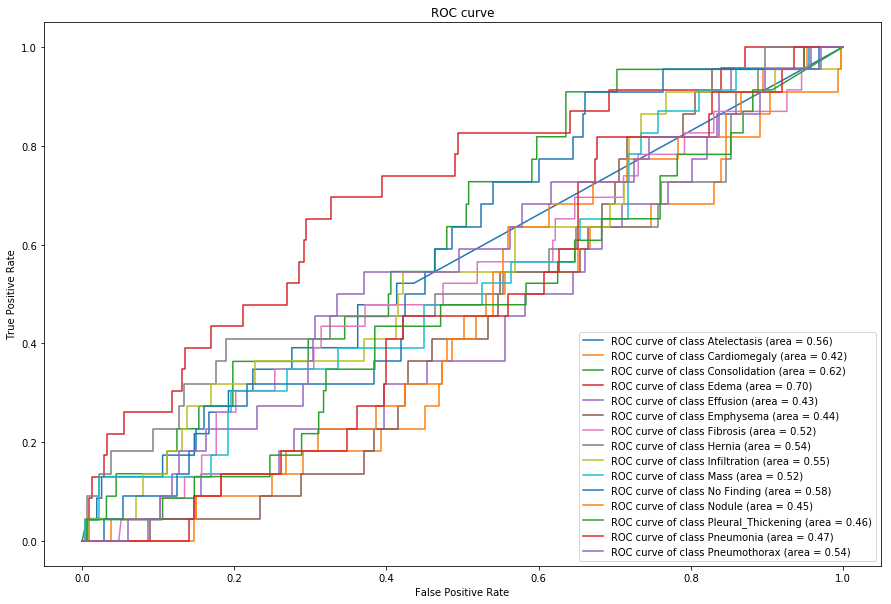

In [21]:
# Auc scores
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(validation_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(15,10))
for i in range(validation_generator.num_classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(inv_map[i], roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()